<a href="https://colab.research.google.com/github/racoope70/Credit-Card-Fraud-Detection/blob/main/SMOTE_%2B_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from google.colab import drive

# Step 3: Mount Google Drive
drive.mount('/content/drive')

# Load the uploaded Credit Card Fraud Detection dataset
file_path = '/content/drive/MyDrive/cleaned_creditcard_data.csv'
cleaned_creditcard_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
cleaned_creditcard_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
import joblib

# Load resampled data
X_resampled, y_resampled = joblib.load('/content/drive/My Drive/X_y_resampled.pkl')
print("Resampled data loaded successfully.")



Resampled data loaded successfully.


In [5]:
# Load train/test split
X_train, X_test, y_train, y_test = joblib.load('/content/drive/My Drive/train_test_split.pkl')
print("Train/test split loaded successfully.")

Train/test split loaded successfully.


In [6]:
# Load the best model
best_model = joblib.load('/content/drive/My Drive/best_xgboost_model.pkl')
print("Best model loaded successfully.")

Best model loaded successfully.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:01] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:01] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:01] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [7]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

In [8]:
# Step 1: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Apply ADASYN on top of SMOTE output (further focus on harder-to-classify samples)
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_resampled, y_resampled)

# Verify class distribution after both SMOTE and ADASYN
print("Class Distribution After SMOTE + ADASYN:", Counter(y_resampled))

Class Distribution After SMOTE + ADASYN: Counter({0: 226597, 1: 226597})


In [9]:
# Step 3: Train the XGBoost model on the resampled data
model = XGBClassifier(tree_method='hist', random_state=42)
model.fit(X_resampled, y_resampled)

# Step 4: Evaluate the model
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities
y_pred = model.predict(X_test)  # Predicted class labels


Confusion Matrix:
 [[56643    13]
 [   18    72]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.85      0.80      0.82        90

    accuracy                           1.00     56746
   macro avg       0.92      0.90      0.91     56746
weighted avg       1.00      1.00      1.00     56746


ROC-AUC Score: 0.9661950092566445


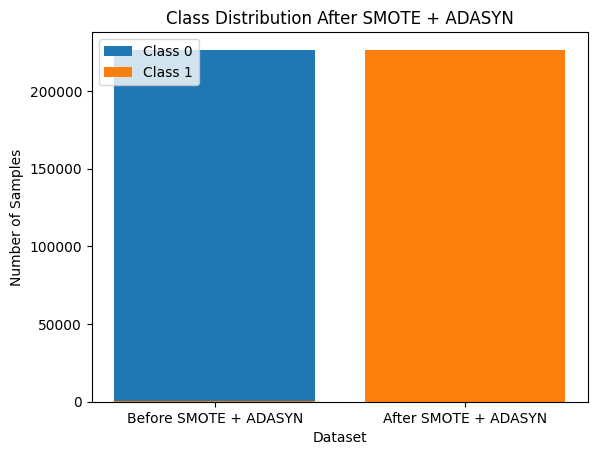

In [10]:
# Performance metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Step 5: Visualize the results
plt.bar(["Before SMOTE + ADASYN", "After SMOTE + ADASYN"],
        [Counter(y_train)[0], Counter(y_resampled)[0]], label='Class 0')
plt.bar(["Before SMOTE + ADASYN", "After SMOTE + ADASYN"],
        [Counter(y_train)[1], Counter(y_resampled)[1]], label='Class 1')
plt.legend()
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE + ADASYN")
plt.show()

In [11]:
pip install --upgrade xgboost scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


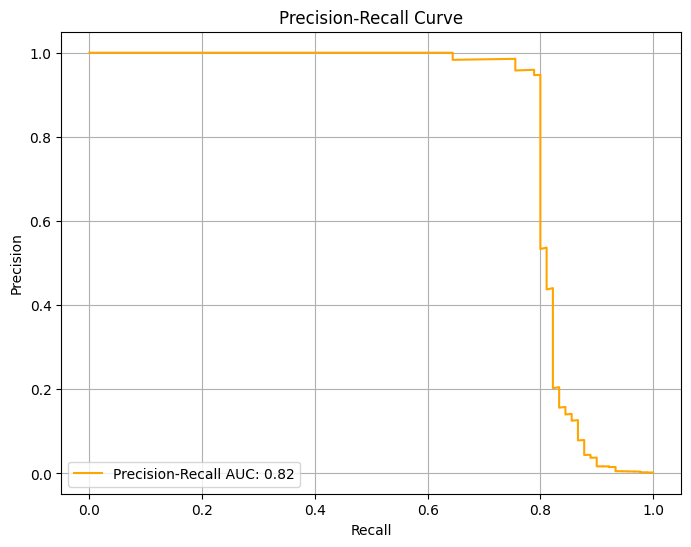

In [12]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall AUC: {pr_auc:.2f}", color='orange')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


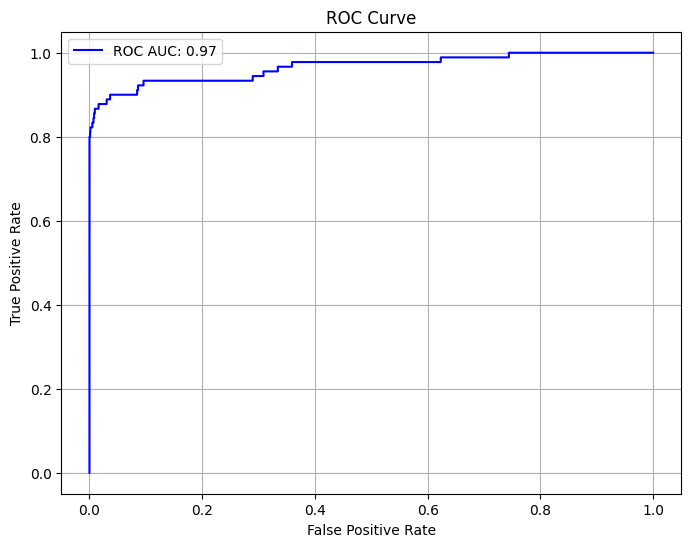

In [13]:
from sklearn.metrics import roc_curve

# Calculate ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.2f}", color='blue')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


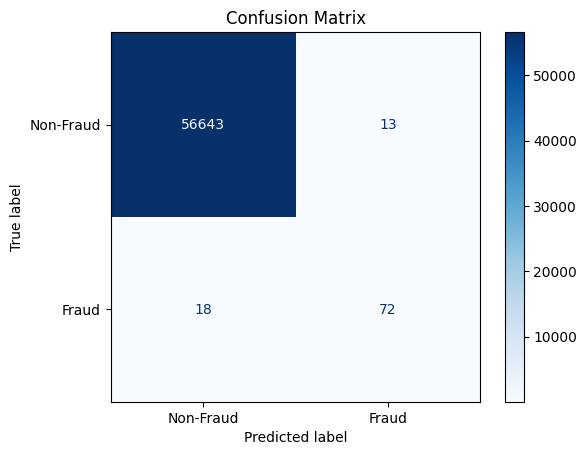

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
